# Preprocesamiento de Datos – Fuentes UNID

Este notebook tiene como objetivo transformar y preparar los datos de las fuentes no identificadas (UNIDs), contenidas en el archivo `unids_3F_beta_err_names.txt`, para su uso en modelos de detección de anomalías como One-Class SVM.

A diferencia de las fuentes ASTRO, las variables de los UNIDs no están logarítmicamente transformadas. Dado que el modelo se entrena con datos ASTRO ya transformados en `log10`, es necesario aplicar la misma transformación a los UNIDs para garantizar la coherencia de escala.

Las variables transformadas serán:
- `E_peak`
- `beta`
- `sigma_det`
- `beta_Rel`

Los datos procesados se guardarán tanto en formato `.csv` como `.txt` para facilitar su reutilización.

In [146]:
# Transformación Logarítmica y Verificación de Compatibilidad - UNIDs Fermi-LAT
# TFG: Utilización de técnicas de ML a datos del satélite Fermi-Lat para detección de posibles fuentes de materia oscura
# Objetivo: Transformar datos UNIDs a escala logarítmica para compatibilidad con modelo OneClassSVM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 12

In [147]:
unids_features = ['E_peak', 'beta', 'sigma_det', 'beta_Rel', 'number']
unids_original = pd.read_csv('../../data/raw/unids_3F_beta_err_names.txt', 
                            sep="\s+", names=unids_features, engine='python', skiprows=1)

print(f"UNIDs cargados: {unids_original.shape}")

print(f"Dimensiones del dataset UNIDs: {unids_original.shape}")
print(f"Número total de fuentes no identificadas: {len(unids_original)}")

UNIDs cargados: (1125, 5)
Dimensiones del dataset UNIDs: (1125, 5)
Número total de fuentes no identificadas: 1125


In [148]:
# Ver muestra
unids_original.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [149]:
unids_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   E_peak     1125 non-null   float64
 1   beta       1125 non-null   float64
 2   sigma_det  1125 non-null   float64
 3   beta_Rel   1125 non-null   float64
 4   number     1125 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 44.1 KB


In [150]:
# Cargar datos de entrenamiento ASTRO (ya en escala logarítmica)
print("Cargando datos de entrenamiento ASTRO...")
training_features = ['E_peak', 'beta', 'sigma', 'beta_Rel', 'astro_DM']
training_full = pd.read_csv('../../data/raw/XY_bal_log_Rel.txt', 
                           sep="\s+", names=training_features, engine='python', skiprows=1)

# Filtrar solo datos ASTRO (clase 0.0) - datos usados para entrenar OneClassSVM
astro_df = training_full[training_full['astro_DM'] == 0.0].copy()

print(f"- Dataset completo cargado: {training_full.shape}")
print(f"- Datos ASTRO extraídos: {astro_df.shape}")

Cargando datos de entrenamiento ASTRO...
- Dataset completo cargado: (5662, 5)
- Datos ASTRO extraídos: (2831, 5)


In [151]:
astro_df.head()

,E_peak,beta,sigma,beta_Rel,astro_DM
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [152]:
astro_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2831 entries, 0 to 2830
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   E_peak    2831 non-null   float64
 1   beta      2831 non-null   float64
 2   sigma     2831 non-null   float64
 3   beta_Rel  2831 non-null   float64
 4   astro_DM  2831 non-null   float64
dtypes: float64(5)
memory usage: 132.7 KB


In [153]:
print("\nUNIDs (escala lineal):")
unids_original[['E_peak', 'beta', 'sigma_det', 'beta_Rel']].describe()


UNIDs (escala lineal):


,E_peak,beta,sigma_det,beta_Rel
count,1125.000000,1125.000000,1125.000000,1125.000000
mean,6.035556,0.347647,8.310279,0.936490
std,89.583292,0.236009,5.601328,2.808888
min,0.000002,0.002400,4.055600,0.000900
25%,0.376570,0.159000,5.117300,0.362970
50%,0.811710,0.305800,6.509900,0.547970
75%,1.702900,0.493200,9.208800,0.889688
max,2950.500000,1.000000,50.308300,74.954225


In [154]:
print("\nDatos ASTRO - Entrenamiento OneClassSVM (escala logarítmica):")
astro_df[['E_peak', 'beta', 'sigma', 'beta_Rel']].describe()


Datos ASTRO - Entrenamiento OneClassSVM (escala logarítmica):


,E_peak,beta,sigma,beta_Rel
count,2831.000000,2831.000000,2831.000000,2831.000000
mean,-0.086668,-0.935025,1.112434,-0.219436
std,1.280269,0.425847,0.370543,0.447146
min,-5.912006,-2.602060,0.609189,-3.198657
25%,-0.683526,-1.190440,0.819636,-0.431508
50%,0.008004,-0.935917,1.037837,-0.185014
75%,0.689384,-0.643496,1.328710,0.026877
max,5.918502,0.000000,2.899104,1.629309


## Verificaciones

In [155]:
feature_cols = ['E_peak', 'beta', 'sigma_det', 'beta_Rel']

print("Verificando valores ≤ 0 que causarían problemas con log₁₀:")

problematic_values = {}
for col in feature_cols:
    zero_count = (unids_original[col] == 0).sum()
    negative_count = (unids_original[col] < 0).sum()
    min_positive = unids_original[unids_original[col] > 0][col].min() if (unids_original[col] > 0).any() else None
    
    problematic_values[col] = {
        'zeros': zero_count,
        'negatives': negative_count,
        'min_positive': min_positive,
        'total_problematic': zero_count + negative_count
    }
    
    print(f"\n{col}:")
    print(f"  • Valores = 0: {zero_count}")
    print(f"  • Valores < 0: {negative_count}")
    print(f"  • Valores problemáticos totales: {zero_count + negative_count}")
    print(f"  • Valor positivo mínimo: {min_positive}")
    
    if zero_count + negative_count > 0:
        print(f" ATENCIÓN: {zero_count + negative_count} valores problemáticos")
        # Mostrar algunos ejemplos
        problematic_indices = unids_original[unids_original[col] <= 0].index[:5]
        if len(problematic_indices) > 0:
            print(f"  Primeros índices problemáticos: {problematic_indices.tolist()}")
    else:
        print(f"Sin valores problemáticos")

Verificando valores ≤ 0 que causarían problemas con log₁₀:

E_peak:
  • Valores = 0: 0
  • Valores < 0: 0
  • Valores problemáticos totales: 0
  • Valor positivo mínimo: 2.3549e-06
Sin valores problemáticos

beta:
  • Valores = 0: 0
  • Valores < 0: 0
  • Valores problemáticos totales: 0
  • Valor positivo mínimo: 0.0024
Sin valores problemáticos

sigma_det:
  • Valores = 0: 0
  • Valores < 0: 0
  • Valores problemáticos totales: 0
  • Valor positivo mínimo: 4.0556
Sin valores problemáticos

beta_Rel:
  • Valores = 0: 0
  • Valores < 0: 0
  • Valores problemáticos totales: 0
  • Valor positivo mínimo: 0.0009
Sin valores problemáticos


In [156]:
# Definir estrategia basada en valores problemáticos
total_problematic = sum([v['total_problematic'] for v in problematic_values.values()])

if total_problematic > 0:
    print(f"Se encontraron {total_problematic} valores problemáticos totales")
    print("\nEstrategia adoptada:")
    print("1. Aplicar transformación log10 a valores positivos")
    print("2. Para valores ≤ 0: aplicar log10 (valor + epsilon) donde epsilon = 1e-10")
    print("3. Verificar que no se introduzcan artifacts")
    
    epsilon = 1e-10
    print(f"\nEpsilon utilizado: {epsilon}")
else:
    print("No hay valores problemáticos")
    print("Estrategia: Aplicar log10 directamente")
    epsilon = 0

No hay valores problemáticos
Estrategia: Aplicar log10 directamente


## Transformación de las columnas de UNIDS a log(10)

In [157]:
# Crear copia para transformación
unids_transformed = unids_original.copy()

print("Aplicando transformación log₁₀...")

# Aplicar transformación a cada variable
transformation_log = {}

for col in feature_cols:
    original_col = col
    
    if epsilon > 0:
        # Aplicar epsilon para valores problemáticos
        transformed_values = np.log10(unids_transformed[col] + epsilon)
        transformation_log[col] = f"log₁₀({col} + {epsilon})"
    else:
        # Aplicar log₁₀ directamente
        transformed_values = np.log10(unids_transformed[col])
        transformation_log[col] = f"log₁₀({col})"
    
    unids_transformed[col] = transformed_values
    print(f"- {col}: {transformation_log[col]}")

Aplicando transformación log₁₀...
- E_peak: log₁₀(E_peak)
- beta: log₁₀(beta)
- sigma_det: log₁₀(sigma_det)
- beta_Rel: log₁₀(beta_Rel)


In [158]:
print("\nESTADÍSTICAS DESPUÉS DE TRANSFORMACIÓN:")
print("\nUNIDs (escala logarítmica):")
print(unids_transformed[feature_cols].describe())


ESTADÍSTICAS DESPUÉS DE TRANSFORMACIÓN:

UNIDs (escala logarítmica):
            E_peak         beta    sigma_det     beta_Rel
count  1125.000000  1125.000000  1125.000000  1125.000000
mean     -0.145919    -0.591713     0.861215    -0.232619
std       0.831012     0.391782     0.203916     0.357331
min      -5.628028    -2.619789     0.608055    -3.045757
25%      -0.424154    -0.798603     0.709041    -0.440129
50%      -0.090599    -0.514563     0.813574    -0.261243
75%       0.231189    -0.306977     0.964203    -0.050762
max       3.469896     0.000000     1.701640     1.874796


In [159]:
print("Comparando rangos entre UNIDs transformados y datos ASTRO (usados para entrenar OneClassSVM):")

compatibility_check = {}
for i, col in enumerate(['E_peak', 'beta', 'sigma_det', 'beta_Rel']):
    astro_col = 'sigma' if col == 'sigma_det' else col
    
    # Rangos
    unid_min, unid_max = unids_transformed[col].min(), unids_transformed[col].max()
    astro_min, astro_max = astro_df[astro_col].min(), astro_df[astro_col].max()
    
    # Verificar superposición
    overlap_min = max(unid_min, astro_min)
    overlap_max = min(unid_max, astro_max)
    has_overlap = overlap_min <= overlap_max
    
    # Verificar si UNIDs están dentro del rango ASTRO
    within_range = (unid_min >= astro_min) and (unid_max <= astro_max)
    
    # Calcular porcentaje de superposición
    if has_overlap:
        overlap_range = overlap_max - overlap_min
        astro_range = astro_max - astro_min
        overlap_percentage = (overlap_range / astro_range) * 100 if astro_range > 0 else 0
    else:
        overlap_percentage = 0
    
    compatibility_check[col] = {
        'unid_range': (unid_min, unid_max),
        'astro_range': (astro_min, astro_max),
        'overlap': has_overlap,
        'within_astro_range': within_range,
        'overlap_range': (overlap_min, overlap_max) if has_overlap else None,
        'overlap_percentage': overlap_percentage
    }
    
    print(f"\n{col} ↔ ASTRO {astro_col}:")
    print(f"  UNIDs transformados: [{unid_min:.3f}, {unid_max:.3f}]")
    print(f"  Datos ASTRO:         [{astro_min:.3f}, {astro_max:.3f}]")
    print(f"  Superposición: {'Sí' if has_overlap else 'No'}")
    print(f"  UNIDs dentro rango ASTRO: {'Sí' if within_range else 'No'}")
    
    if has_overlap:
        print(f"  Rango superposición: [{overlap_min:.3f}, {overlap_max:.3f}]")
        print(f"  % de superposición: {overlap_percentage:.1f}%")
    
    # Advertencias específicas
    if not has_overlap:
        print(f" SIN SUPERPOSICIÓN: Modelo puede no funcionar bien")
    elif overlap_percentage < 50:
        print(f"SUPERPOSICIÓN BAJA: Verificar performance del modelo")
    elif within_range:
        print(f"COMPATIBILIDAD EXCELENTE: UNIDs dentro del espacio ASTRO")


Comparando rangos entre UNIDs transformados y datos ASTRO (usados para entrenar OneClassSVM):

E_peak ↔ ASTRO E_peak:
  UNIDs transformados: [-5.628, 3.470]
  Datos ASTRO:         [-5.912, 5.919]
  Superposición: Sí
  UNIDs dentro rango ASTRO: Sí
  Rango superposición: [-5.628, 3.470]
  % de superposición: 76.9%
COMPATIBILIDAD EXCELENTE: UNIDs dentro del espacio ASTRO

beta ↔ ASTRO beta:
  UNIDs transformados: [-2.620, 0.000]
  Datos ASTRO:         [-2.602, 0.000]
  Superposición: Sí
  UNIDs dentro rango ASTRO: No
  Rango superposición: [-2.602, 0.000]
  % de superposición: 100.0%

sigma_det ↔ ASTRO sigma:
  UNIDs transformados: [0.608, 1.702]
  Datos ASTRO:         [0.609, 2.899]
  Superposición: Sí
  UNIDs dentro rango ASTRO: No
  Rango superposición: [0.609, 1.702]
  % de superposición: 47.7%
SUPERPOSICIÓN BAJA: Verificar performance del modelo

beta_Rel ↔ ASTRO beta_Rel:
  UNIDs transformados: [-3.046, 1.875]
  Datos ASTRO:         [-3.199, 1.629]
  Superposición: Sí
  UNIDs dentro

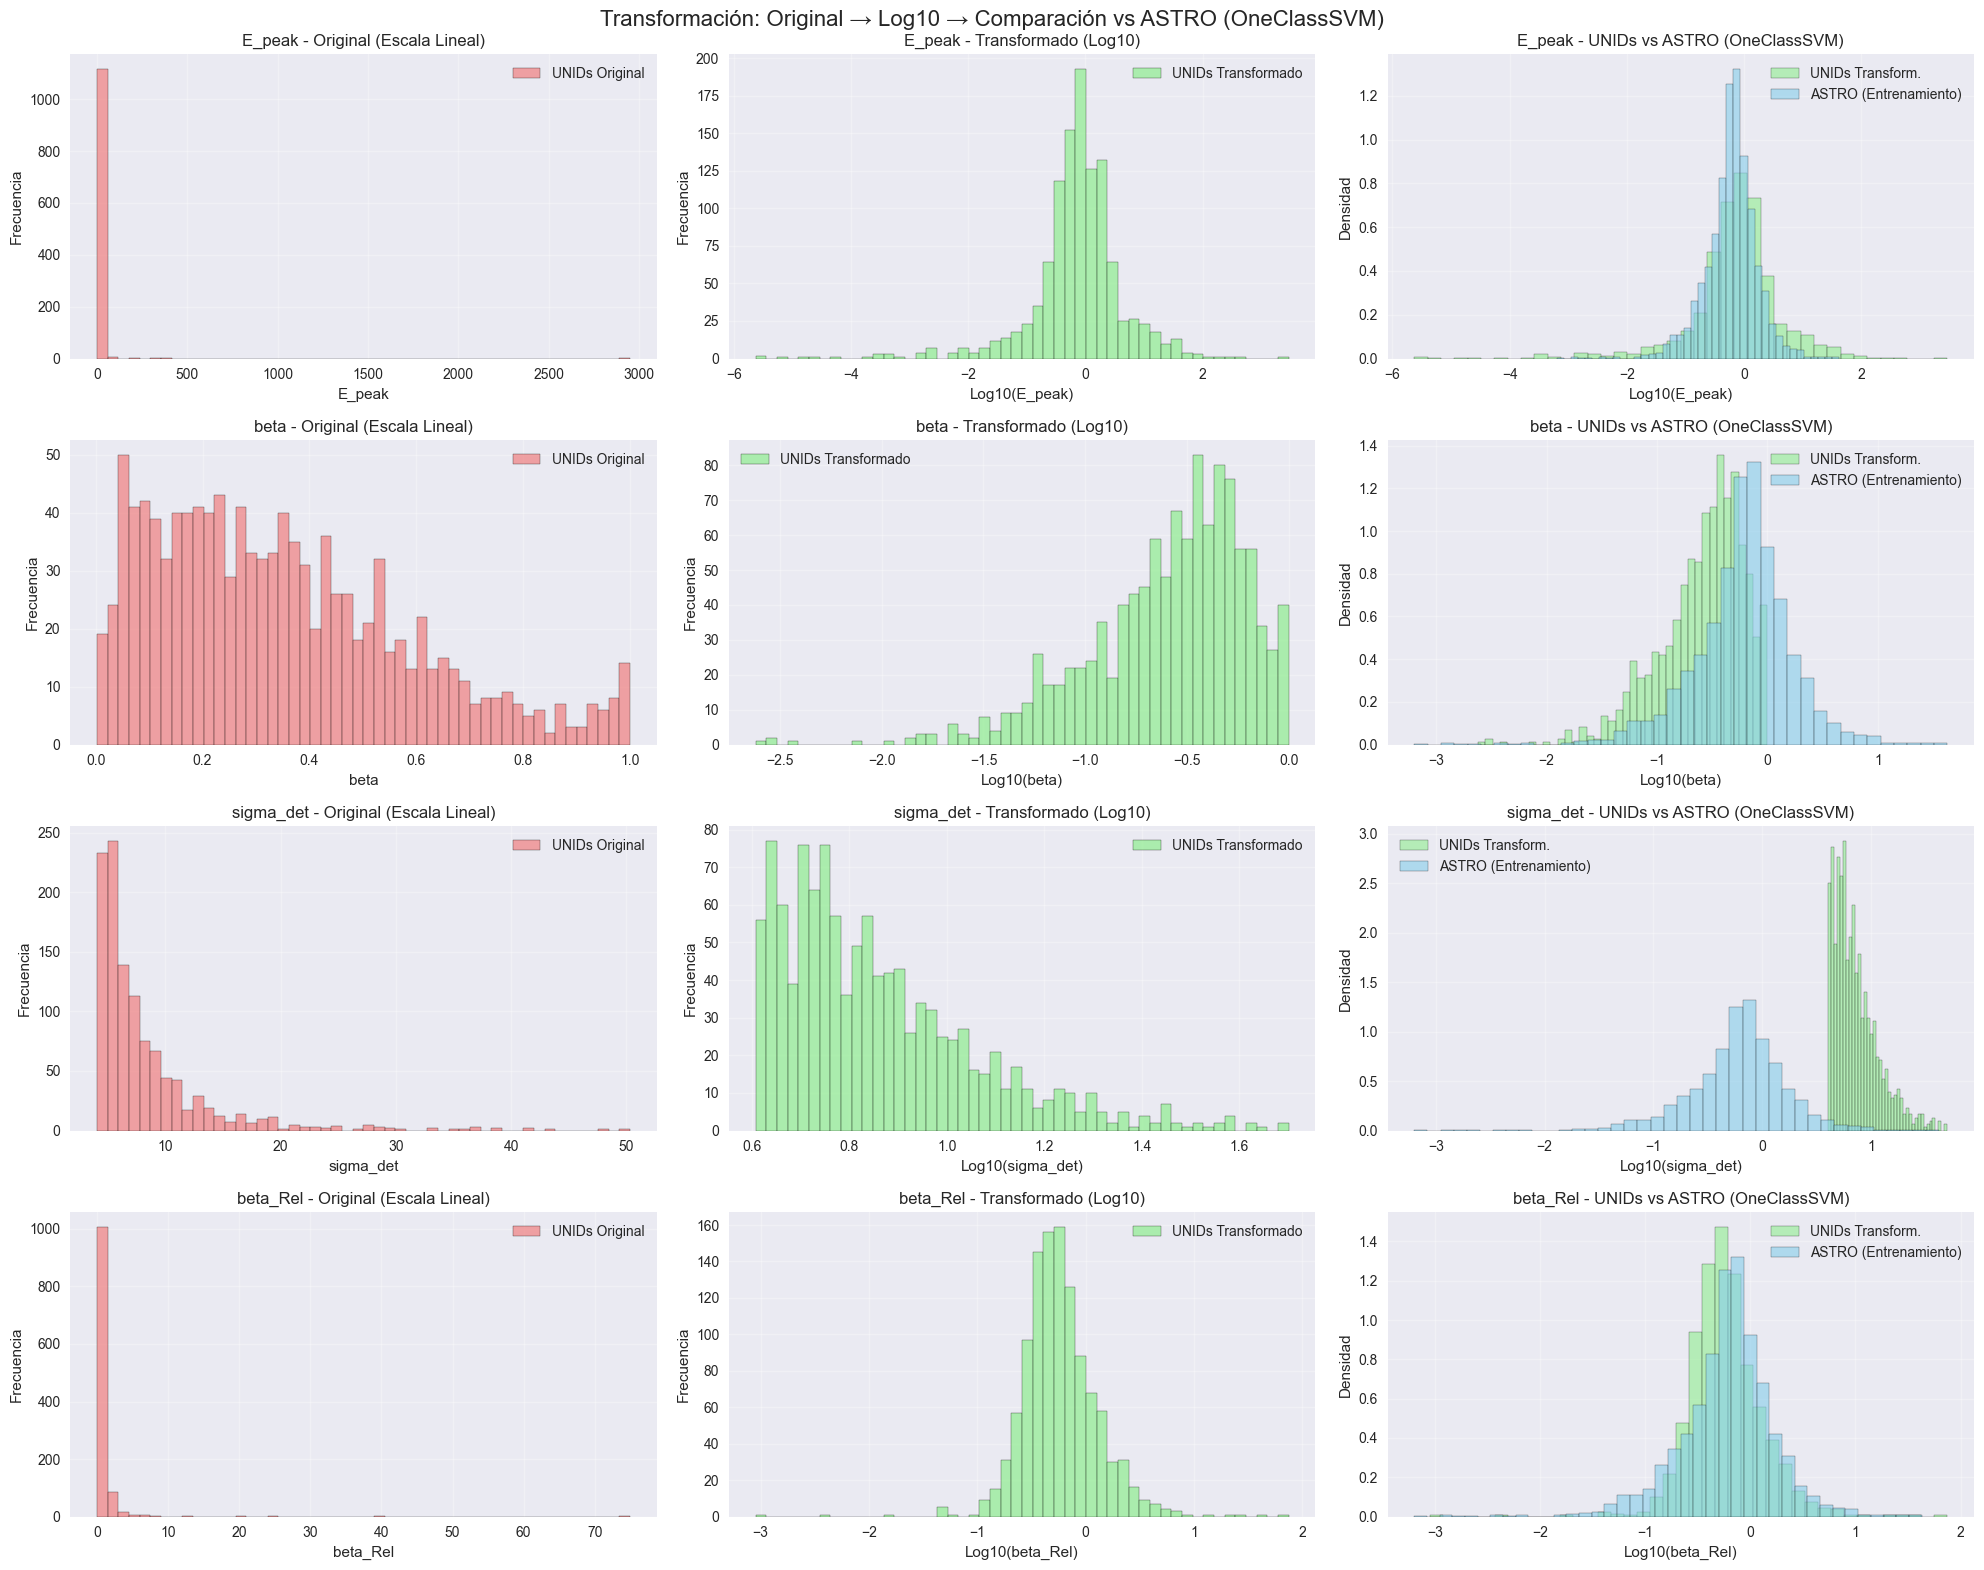

In [160]:
# Crear visualización antes vs después
fig, axes = plt.subplots(4, 3, figsize=(20, 16))

for i, col in enumerate(feature_cols):
    train_col = 'sigma' if col == 'sigma_det' else col
    
    # Distribución original UNIDs
    axes[i, 0].hist(unids_original[col], bins=50, alpha=0.7, color='lightcoral', 
                   edgecolor='black', label='UNIDs Original')
    axes[i, 0].set_title(f'{col} - Original (Escala Lineal)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frecuencia')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Distribución transformada UNIDs
    axes[i, 1].hist(unids_transformed[col], bins=50, alpha=0.7, color='lightgreen', 
                   edgecolor='black', label='UNIDs Transformado')
    axes[i, 1].set_title(f'{col} - Transformado (Log10)')
    axes[i, 1].set_xlabel(f'Log10({col})')
    axes[i, 1].set_ylabel('Frecuencia')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    
    # Comparación superpuesta - UNIDs vs ASTRO solamente
    axes[i, 2].hist(unids_transformed[col], bins=40, alpha=0.6, color='lightgreen', 
                   density=True, label='UNIDs Transform.', edgecolor='black')
    axes[i, 2].hist(astro_df[astro_col], bins=40, alpha=0.6, color='skyblue', 
                   density=True, label='ASTRO (Entrenamiento)', edgecolor='black')
    axes[i, 2].set_title(f'{col} - UNIDs vs ASTRO (OneClassSVM)')
    axes[i, 2].set_xlabel(f'Log10({col})')
    axes[i, 2].set_ylabel('Densidad')
    axes[i, 2].legend()
    axes[i, 2].grid(True, alpha=0.3)

plt.suptitle('Transformación: Original → Log10 → Comparación vs ASTRO (OneClassSVM)', 
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


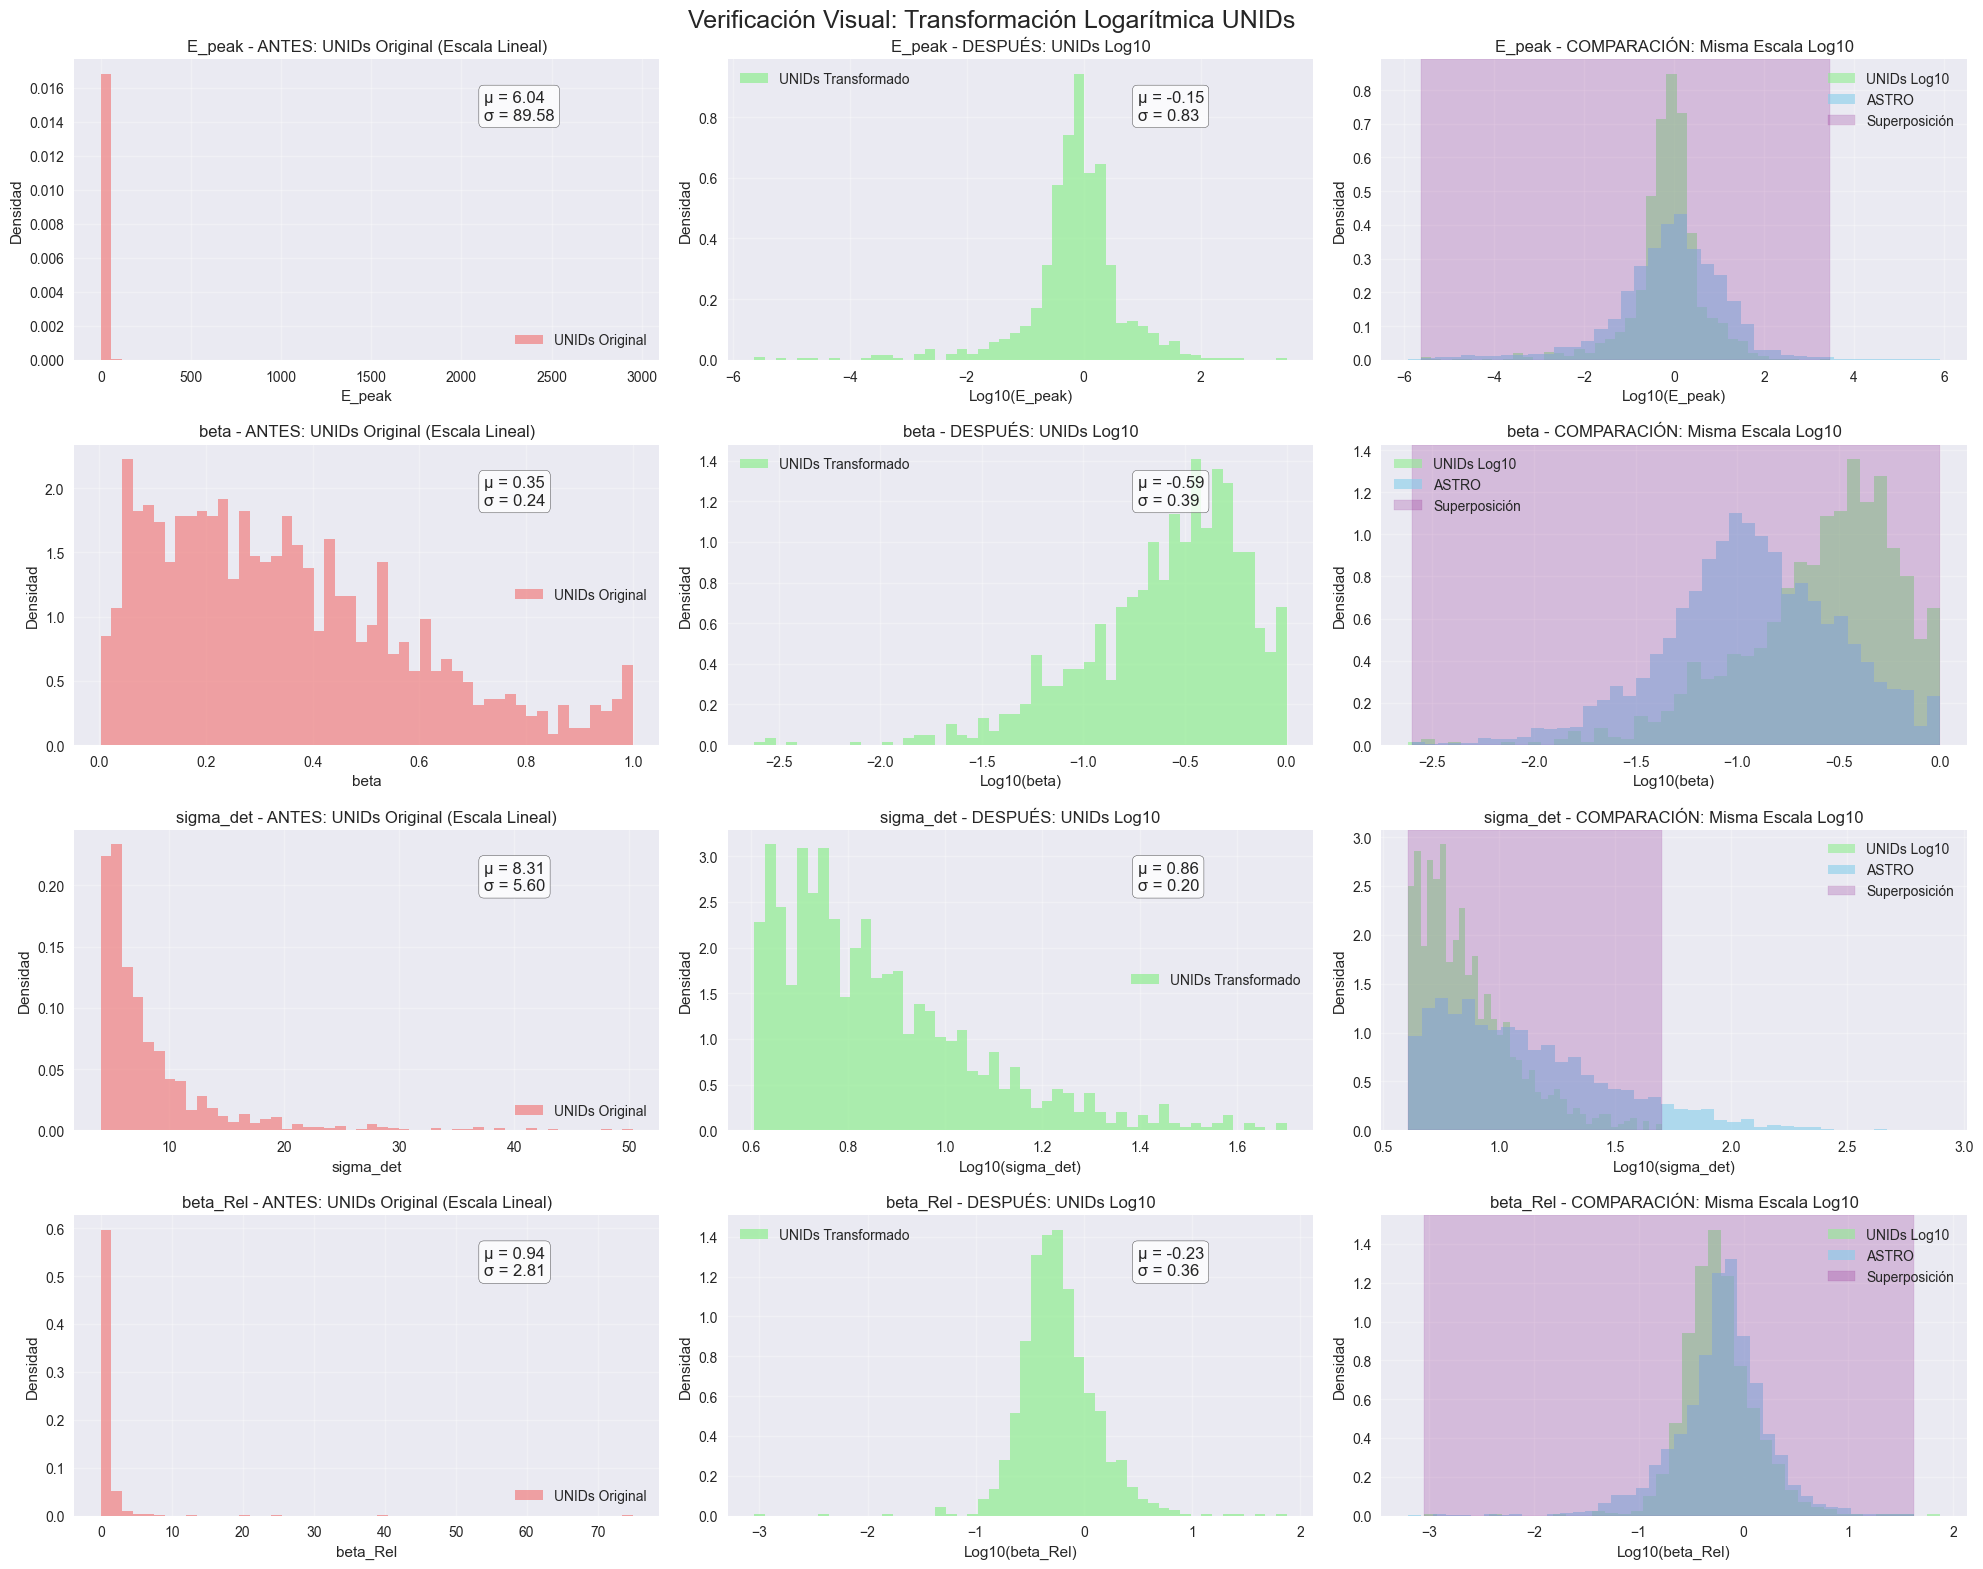

In [161]:
# Crear visualización de distribuciones
fig, axes = plt.subplots(4, 3, figsize=(20, 16))

for i, col in enumerate(feature_cols):
    astro_col = 'sigma' if col == 'sigma_det' else col
    
    # ANTES: UNIDs original vs ASTRO (escalas diferentes)
    axes[i, 0].hist(unids_original[col], bins=50, alpha=0.7, color='lightcoral', 
                   label=f'UNIDs Original', density=True)
    axes[i, 0].set_title(f'{col} - ANTES: UNIDs Original (Escala Lineal)')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Densidad')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Estadísticas en el gráfico
    mean_orig = unids_original[col].mean()
    std_orig = unids_original[col].std()
    axes[i, 0].text(0.7, 0.8, f'μ = {mean_orig:.2f}\nσ = {std_orig:.2f}', 
                   transform=axes[i, 0].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # DESPUÉS: UNIDs transformado
    axes[i, 1].hist(unids_transformed[col], bins=50, alpha=0.7, color='lightgreen', 
                   label=f'UNIDs Transformado', density=True)
    axes[i, 1].set_title(f'{col} - DESPUÉS: UNIDs Log10')
    axes[i, 1].set_xlabel(f'Log10({col})')
    axes[i, 1].set_ylabel('Densidad')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    
    # Estadísticas transformadas
    mean_trans = unids_transformed[col].mean()
    std_trans = unids_transformed[col].std()
    axes[i, 1].text(0.7, 0.8, f'μ = {mean_trans:.2f}\nσ = {std_trans:.2f}', 
                   transform=axes[i, 1].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # COMPARACIÓN: UNIDs transformado vs ASTRO (misma escala)
    axes[i, 2].hist(unids_transformed[col], bins=40, alpha=0.6, color='lightgreen', 
                   density=True, label='UNIDs Log10')
    axes[i, 2].hist(astro_df[astro_col], bins=40, alpha=0.6, color='skyblue', 
                   density=True, label='ASTRO')
    axes[i, 2].set_title(f'{col} - COMPARACIÓN: Misma Escala Log10')
    axes[i, 2].set_xlabel(f'Log10({col})')
    axes[i, 2].set_ylabel('Densidad')
    axes[i, 2].legend()
    axes[i, 2].grid(True, alpha=0.3)
    
    # Mostrar superposición
    unid_min, unid_max = unids_transformed[col].min(), unids_transformed[col].max()
    astro_min, astro_max = astro_df[astro_col].min(), astro_df[astro_col].max()
    overlap_min = max(unid_min, astro_min)
    overlap_max = min(unid_max, astro_max)
    
    if overlap_min <= overlap_max:
        axes[i, 2].axvspan(overlap_min, overlap_max, alpha=0.2, color='purple', label='Superposición')
        axes[i, 2].legend()

plt.suptitle('Verificación Visual: Transformación Logarítmica UNIDs', fontsize=18, y=0.98)
plt.tight_layout()
plt.show()


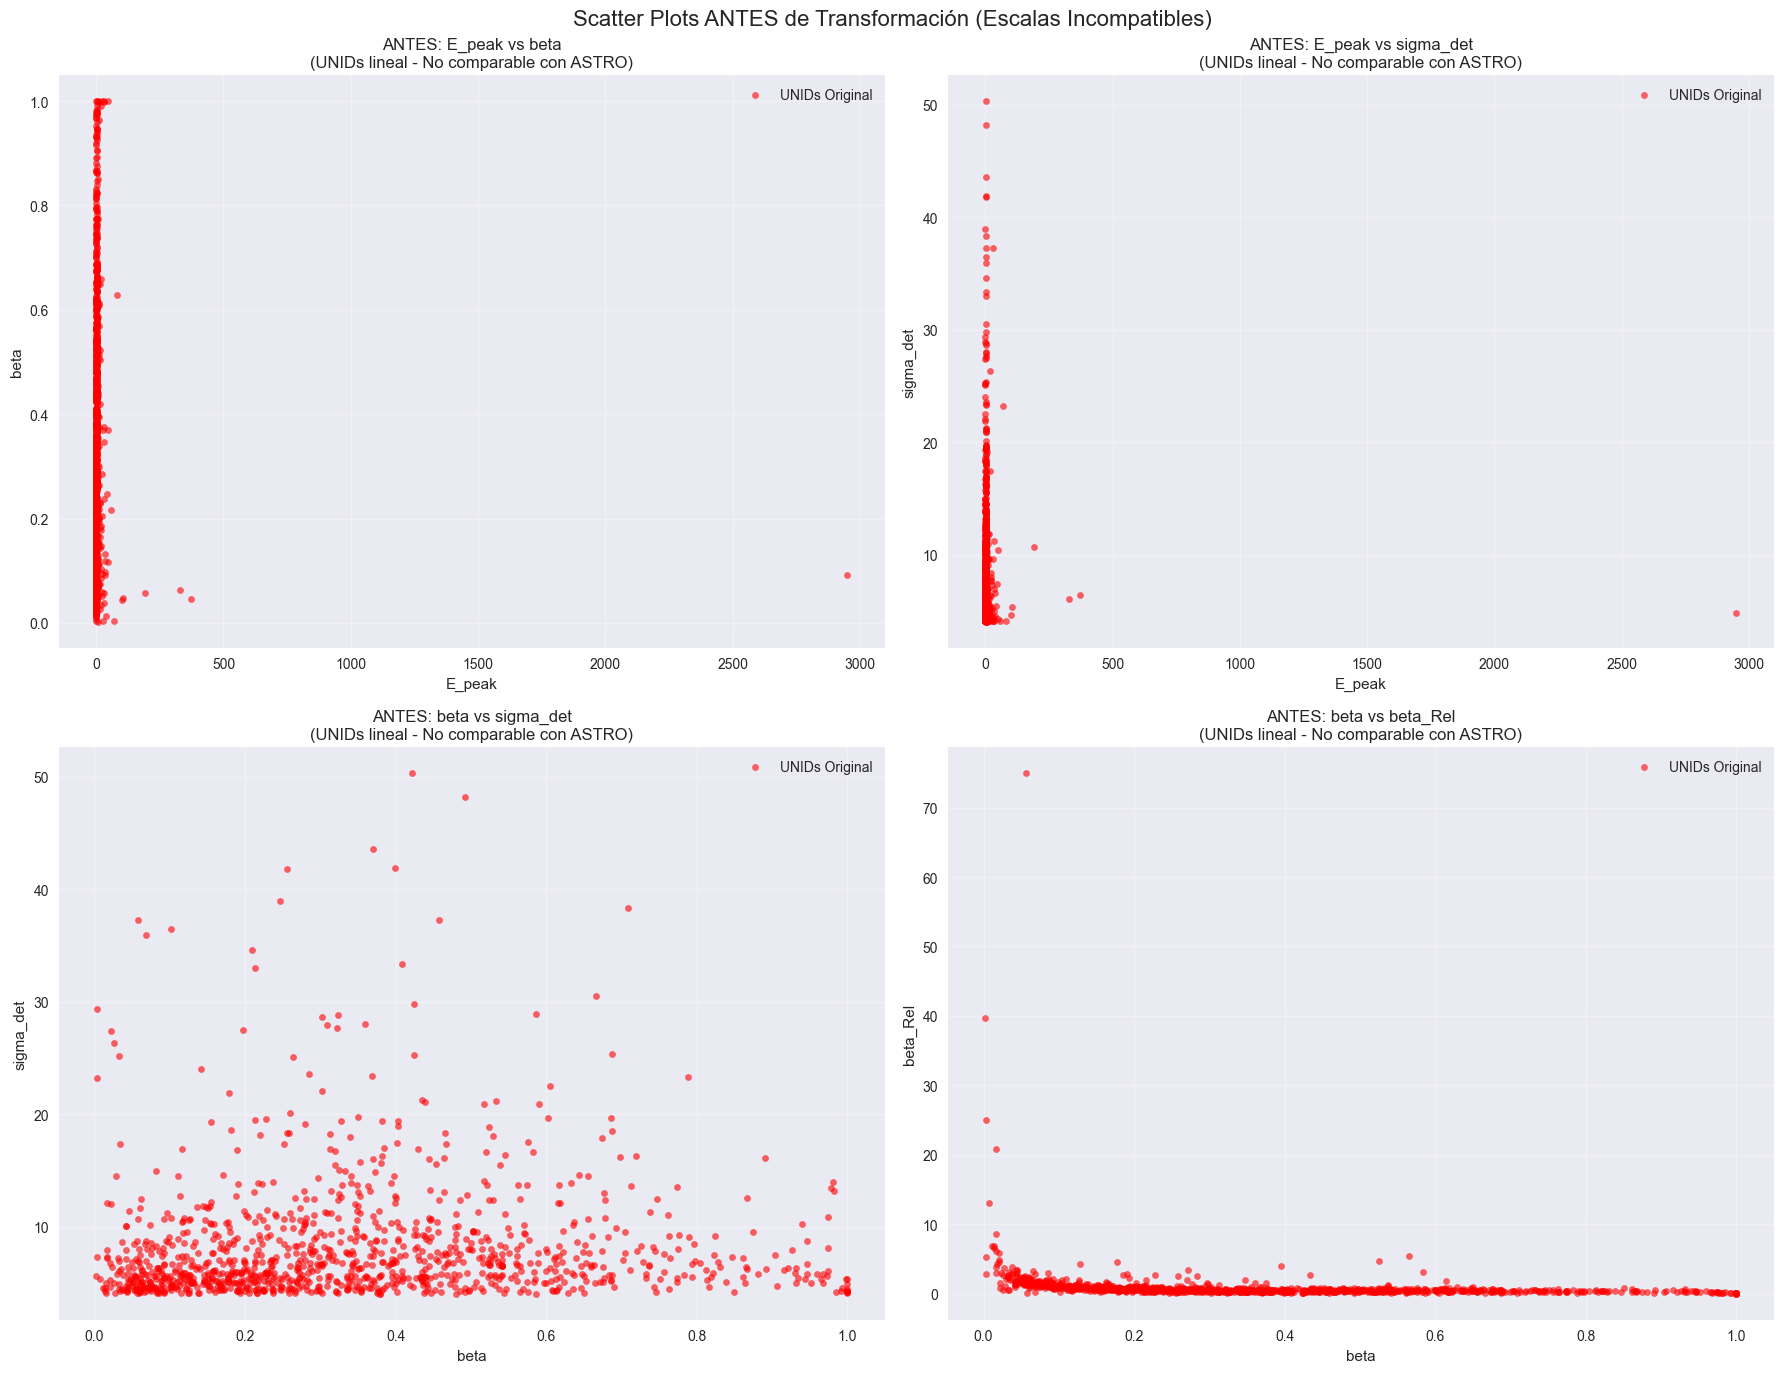

In [162]:
# Pares de variables más importantes
important_pairs = [
    ('E_peak', 'beta'),
    ('E_peak', 'sigma_det'),
    ('beta', 'sigma_det'),
    ('beta', 'beta_Rel')
]

# ANTES DE LA TRANSFORMACIÓN
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

for i, (x_var, y_var) in enumerate(important_pairs):
    astro_x = 'sigma' if x_var == 'sigma_det' else x_var
    astro_y = 'sigma' if y_var == 'sigma_det' else y_var
    
    # UNIDs original (escala lineal)
    axes[i].scatter(unids_original[x_var], unids_original[y_var], 
                   alpha=0.6, c='red', s=20, label='UNIDs Original', marker='o')
    
    # ASTRO (ya en log) - escalar para visualización
    # Nota: No se puede comparar directamente por diferente escala
    axes[i].set_title(f'ANTES: {x_var} vs {y_var}\n(UNIDs lineal - No comparable con ASTRO)')
    axes[i].set_xlabel(x_var)
    axes[i].set_ylabel(y_var)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Scatter Plots ANTES de Transformación (Escalas Incompatibles)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

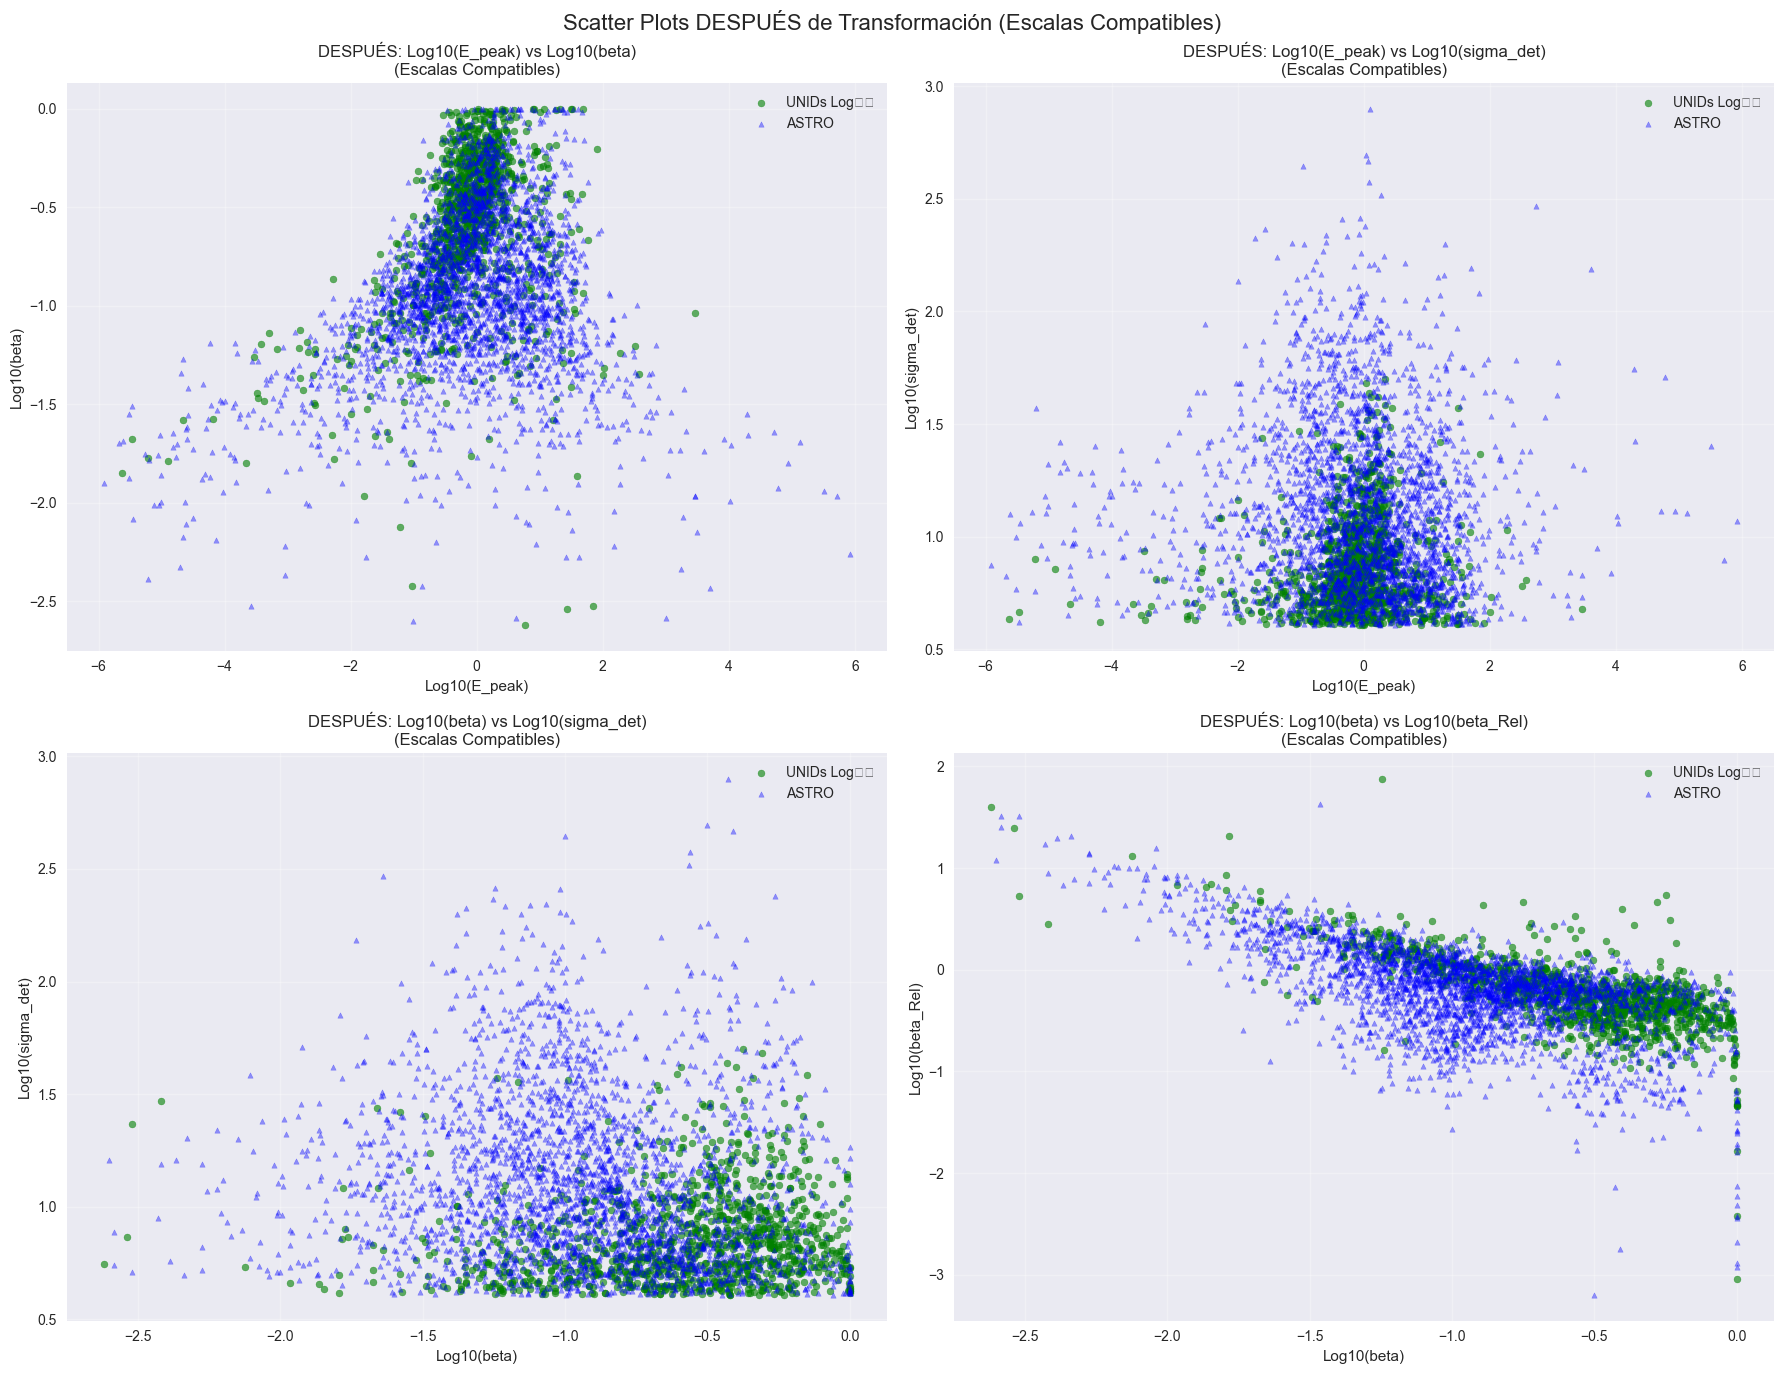

In [163]:
# DESPUÉS DE LA TRANSFORMACIÓN
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.ravel()

for i, (x_var, y_var) in enumerate(important_pairs):
    astro_x = 'sigma' if x_var == 'sigma_det' else x_var
    astro_y = 'sigma' if y_var == 'sigma_det' else y_var
    
    # UNIDs transformado
    axes[i].scatter(unids_transformed[x_var], unids_transformed[y_var], 
                   alpha=0.6, c='green', s=25, label='UNIDs Log₁₀', marker='o')
    
    # ASTRO (referencia)
    axes[i].scatter(astro_df[astro_x], astro_df[astro_y], 
                   alpha=0.4, c='blue', s=15, label='ASTRO', marker='^')
    
    axes[i].set_title(f'DESPUÉS: Log10({x_var}) vs Log10({y_var})\n(Escalas Compatibles)')
    axes[i].set_xlabel(f'Log10({x_var})')
    axes[i].set_ylabel(f'Log10({y_var})')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Scatter Plots DESPUÉS de Transformación (Escalas Compatibles)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

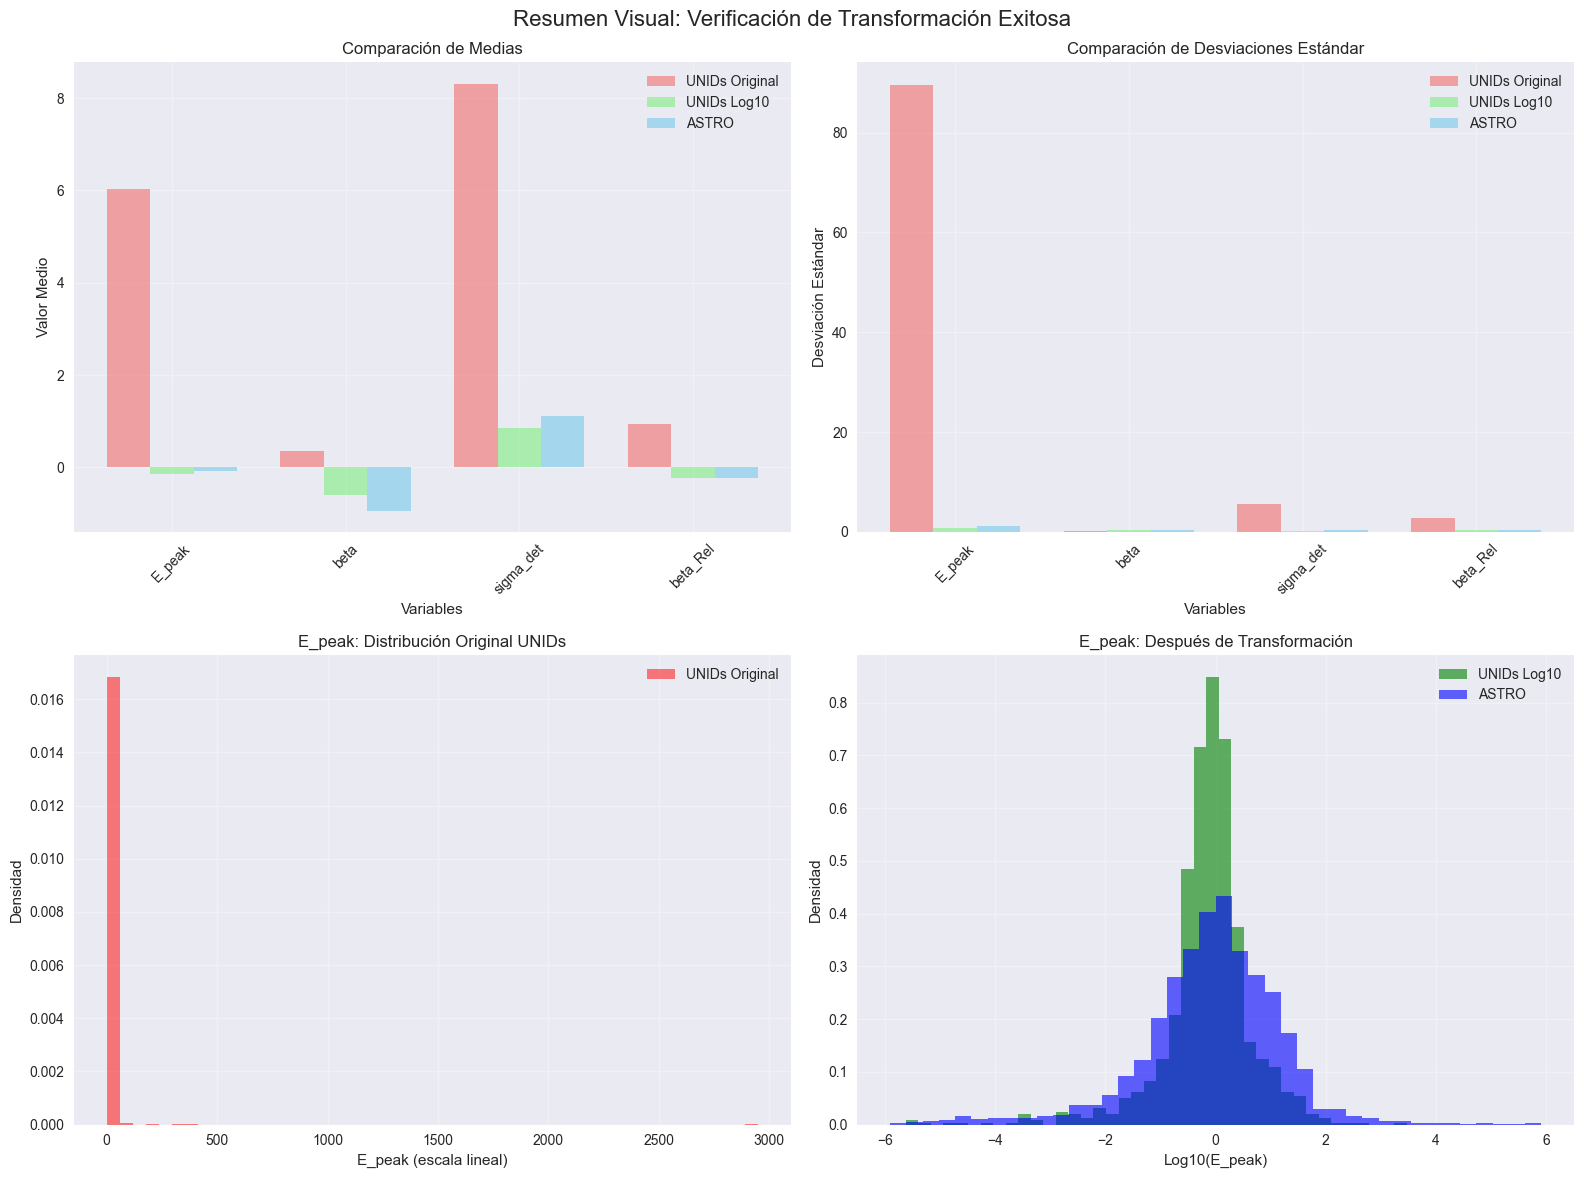

In [164]:
# Crear un resumen estadístico visual
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Resumen de medias antes/después
variables = ['E_peak', 'beta', 'sigma_det', 'beta_Rel']
unids_orig_means = [unids_original[col].mean() for col in variables]
unids_trans_means = [unids_transformed[col].mean() for col in variables]
astro_means = [astro_df['sigma' if col == 'sigma_det' else col].mean() for col in variables]

x_pos = np.arange(len(variables))

ax1.bar(x_pos - 0.25, unids_orig_means, 0.25, label='UNIDs Original', color='lightcoral', alpha=0.7)
ax1.bar(x_pos, unids_trans_means, 0.25, label='UNIDs Log10', color='lightgreen', alpha=0.7)
ax1.bar(x_pos + 0.25, astro_means, 0.25, label='ASTRO', color='skyblue', alpha=0.7)
ax1.set_title('Comparación de Medias')
ax1.set_ylabel('Valor Medio')
ax1.set_xlabel('Variables')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(variables, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Resumen de desviaciones estándar
unids_orig_stds = [unids_original[col].std() for col in variables]
unids_trans_stds = [unids_transformed[col].std() for col in variables]
astro_stds = [astro_df['sigma' if col == 'sigma_det' else col].std() for col in variables]

ax2.bar(x_pos - 0.25, unids_orig_stds, 0.25, label='UNIDs Original', color='lightcoral', alpha=0.7)
ax2.bar(x_pos, unids_trans_stds, 0.25, label='UNIDs Log10', color='lightgreen', alpha=0.7)
ax2.bar(x_pos + 0.25, astro_stds, 0.25, label='ASTRO', color='skyblue', alpha=0.7)
ax2.set_title('Comparación de Desviaciones Estándar')
ax2.set_ylabel('Desviación Estándar')
ax2.set_xlabel('Variables')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(variables, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Histograma conjunto de una variable representativa (E_peak)
ax3.hist(unids_original['E_peak'], bins=50, alpha=0.5, color='red', density=True, label='UNIDs Original')
ax3.set_title('E_peak: Distribución Original UNIDs')
ax3.set_xlabel('E_peak (escala lineal)')
ax3.set_ylabel('Densidad')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Histograma después de transformación
ax4.hist(unids_transformed['E_peak'], bins=40, alpha=0.6, color='green', density=True, label='UNIDs Log10')
ax4.hist(astro_df['E_peak'], bins=40, alpha=0.6, color='blue', density=True, label='ASTRO')
ax4.set_title('E_peak: Después de Transformación')
ax4.set_xlabel('Log10(E_peak)')
ax4.set_ylabel('Densidad')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Resumen Visual: Verificación de Transformación Exitosa', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


In [165]:
# Renombrar columnas para consistencia
final_column_mapping = {
    'E_peak': 'Log(E_peak)',
    'beta': 'Log(beta)',
    'sigma_det': 'Log(sigma)',
    'beta_Rel': 'Log(beta_Rel)',
    'number': 'number'
}

unids_final = unids_transformed.rename(columns=final_column_mapping)

print("Columnas renombradas para consistencia:")
for old_name, new_name in final_column_mapping.items():
    print(f"  {old_name} → {new_name}")

Columnas renombradas para consistencia:
  E_peak → Log(E_peak)
  beta → Log(beta)
  sigma_det → Log(sigma)
  beta_Rel → Log(beta_Rel)
  number → number


In [166]:
print(f"\nDataset final UNIDs transformado:")
print(f"Dimensiones: {unids_final.shape}")
print(f"Columnas: {list(unids_final.columns)}")


Dataset final UNIDs transformado:
Dimensiones: (1125, 5)
Columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'number']


In [167]:
print("\nPrimeras 5 filas del dataset transformado:")
unids_final.head()


Primeras 5 filas del dataset transformado:


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


In [168]:
print("\nÚltimas 5 filas del dataset transformado:")
unids_final.tail()


Últimas 5 filas del dataset transformado:


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),number
1120,-2.564474,-1.218963,0.686672,0.199875,1120
1121,0.030154,-0.367441,0.968758,-0.347451,1121
1122,-0.605023,-0.768530,1.163892,-0.327837,1122
1123,-1.627585,-1.198596,0.708786,0.173108,1123
1124,-0.122335,-0.212044,0.726417,-0.212191,1124


## Generar y guardar archivos con UNIDs transformados

In [ ]:
# Dataset completo transformado (con IDs)
unids_final.to_csv('../../data/processed/unids_log/unids_transformed_complete.csv', index=False)
unids_final.to_csv('../../data/processed/unids_log/unids_transformed_complete.txt', sep='\t', index=False)
print("- unids_transformed_complete.csv / .txt")

# Mapeo de IDs para trazabilidad (POR SI ACASO FALLASE ALGO UN DÍA)
id_mapping = unids_final[['number']].copy()
id_mapping['original_index'] = range(len(id_mapping))
id_mapping.to_csv('../../data/processed/unids_log/unids_transformed_id_mapping.csv', index=False)
print("- unids_transformed_id_mapping.csv")

# Log de transformación aplicada
transformation_log_df = pd.DataFrame([
    {'variable': var, 'transformation': transform, 'epsilon_used': epsilon}
    for var, transform in transformation_log.items()
])
transformation_log_df.to_csv('../../data/processed/unids_log/unids_transformation_log.csv', index=False)
print("- unids_transformation_log.csv")

- unids_transformed_complete.csv / .txt
- unids_transformed_id_mapping.csv
- unids_transformation_log.csv


## Conclusión

Con esta transformación, las fuentes UNID están ahora en la misma escala logarítmica que las fuentes ASTRO. Este paso es esencial para evitar inconsistencias al aplicar modelos de detección de anomalías como One-Class SVM.

Los archivos resultantes (`unids_log.csv` y `unids_log.txt`) están listos para ser utilizados en los notebooks de análisis y predicción posteriores.

## Comparación visual antes y después de la transformación logarítmica

Para comprobar la consistencia entre los datos UNID y ASTRO, se comparan ambas fuentes primero en su escala original y luego tras aplicar la transformación logarítmica base 10 (`log10`) a los UNIDs.

- En escala original, los valores de `E_peak` y `beta` de los UNIDs se encuentran en un rango muy diferente al de los ASTRO.
- Una vez transformados a escala `log10`, los valores de UNIDs se alinean mejor con los de ASTRO, lo que valida la transformación y confirma que ahora los conjuntos son comparables.

Esta transformación es esencial para asegurar la coherencia cuando se utilice el modelo One-Class SVM entrenado exclusivamente con datos ASTRO.